In [11]:
import os
import json
import pandas as pd

word_dictionary = pd.read_csv("../data/raw/word/word_dictionary.csv", sep=',')

word_level_dict = word_dictionary.set_index('Word')['Level'].to_dict()

# JSON 파일을 읽어서 srcText, question, ansM1, ansType 데이터를 추출하는 함수
def json_files_to_content_list(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8-sig') as f:
                try:
                    json_data = json.load(f)
                    # srcText, question, ansM1, ansType 데이터 추출
                    extracted_data = extract_columns_from_json(json_data)
                    all_data.extend(extracted_data)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from file {filename}: {e}")
    
    return all_data

def extract_columns_from_json(json_data):
    extracted_data = []
    ans_type_to_question_type = {
        "명시적": "PT02",
        "함축적": "PT03"
    }
    if 'paragraphInfo' in json_data:
        isbn = json_data['isbn']
        for item in json_data['paragraphInfo']:
            src_text_id = item.get('srcTextID', "")
            src_text = item.get("srcText", "")
            que_ans_pairs = item.get("queAnsPairInfo", [])
            
            for pair in que_ans_pairs:
                classification = pair.get("classification", "")
                question = pair.get("question", "")
                ans_m1 = pair.get("ansM1", "")
                question_type = ans_type_to_question_type.get(pair.get("ansType", ""), "")
                extracted_data.append({
                    "isbn": isbn,
                    "textID": src_text_id,
                    "classification": classification,
                    "text": src_text,
                    "question": question,
                    "answer": ans_m1,
                    "questionType": question_type
                })
    return extracted_data

# JSON 파일 경로 설정 및 데이터 추출
folder_path_pre = "C:/workspace/project_bigdata/data/story_test_data/preschool"
folder_path_123 = "C:/workspace/project_bigdata/data/story_test_data/school_123"
folder_path_456 = "C:/workspace/project_bigdata/data/story_test_data/school_456"

storypre_data = json_files_to_content_list(folder_path_pre)
story123_data = json_files_to_content_list(folder_path_123)
story456_data = json_files_to_content_list(folder_path_456)

In [12]:
# DataFrame 생성 및 데이터 추가
storypre = pd.DataFrame(storypre_data)
story123 = pd.DataFrame(story123_data)
story456 = pd.DataFrame(story456_data)

def calculate_word_metrics(content, word_level_dict):
    words = content.split()
    word_count = len(words)
    length = len(content)
    
    levels = [word_level_dict[word] for word in words if word in word_level_dict]
    
    if levels:
        word_avg = sum(levels) / len(levels)
        word_high = max(levels)
    else:
        word_avg = 0
        word_high = 0
    
    return word_count, word_avg, word_high, length

storypre[['word_count', 'word_avg', 'word_hard', 'length']] = storypre['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
story123[['word_count', 'word_avg', 'word_hard', 'length']] = story123['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
story456[['word_count', 'word_avg', 'word_hard', 'length']] = story456['text'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)

In [13]:
storypre = storypre[storypre['word_hard'] > 0].reset_index(drop=True)
story123 = story123[story123['word_hard'] > 0].reset_index(drop=True)
story456 = story456[story456['word_hard'] > 0].reset_index(drop=True)

In [14]:
storypre.to_csv("../data/processed/story/detail/storypre.csv", sep=',', encoding='utf-8-sig', index=False)
story123.to_csv("../data/processed/story/detail/story123.csv", sep=',', encoding='utf-8-sig', index=False)
story456.to_csv("../data/processed/story/detail/story456.csv", sep=',', encoding='utf-8-sig', index=False)

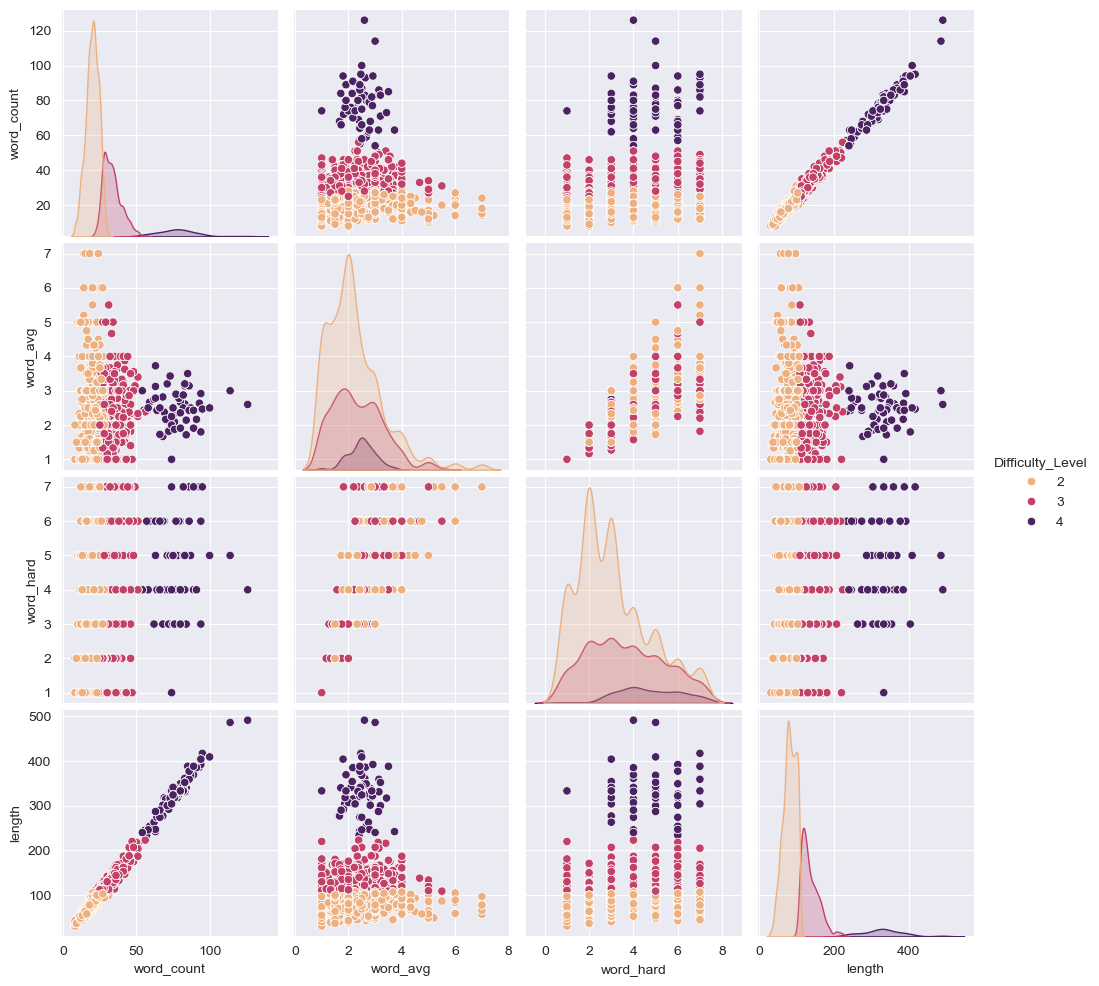

Saved difficulty levels to ../data/processed/story/detail/story123_level.csv


In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# K-means 적용
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
story123['Cluster'] = kmeans.fit_predict(story123[['word_count', 'word_avg', 'word_hard', 'length']])

# word_high 평균값이 높은 클러스터부터 높은 난이도로 분류
cluster_avg = story123.groupby('Cluster')['word_hard'].mean().sort_values()
cluster_avg_rank = cluster_avg.rank().astype(int)+1
difficulty_mapping = {cluster: rank for cluster, rank in zip(cluster_avg.index, cluster_avg_rank)}
story123['Difficulty_Level'] = story123['Cluster'].map(difficulty_mapping)

# 시각화
features = ['word_count', 'word_avg', 'word_hard', 'length', 'Difficulty_Level']
sns_plot = sns.pairplot(story123[features], hue='Difficulty_Level', palette='flare')
image_path = "../data/processed/story/detail/story123_level_pairplot.png"
sns_plot.savefig(image_path)
plt.show()


file_path = "../data/processed/story/detail/story123_level.csv"
story123.to_csv(file_path, index=False, sep=',', encoding='utf-8-sig')
print(f"Saved difficulty levels to {file_path}")

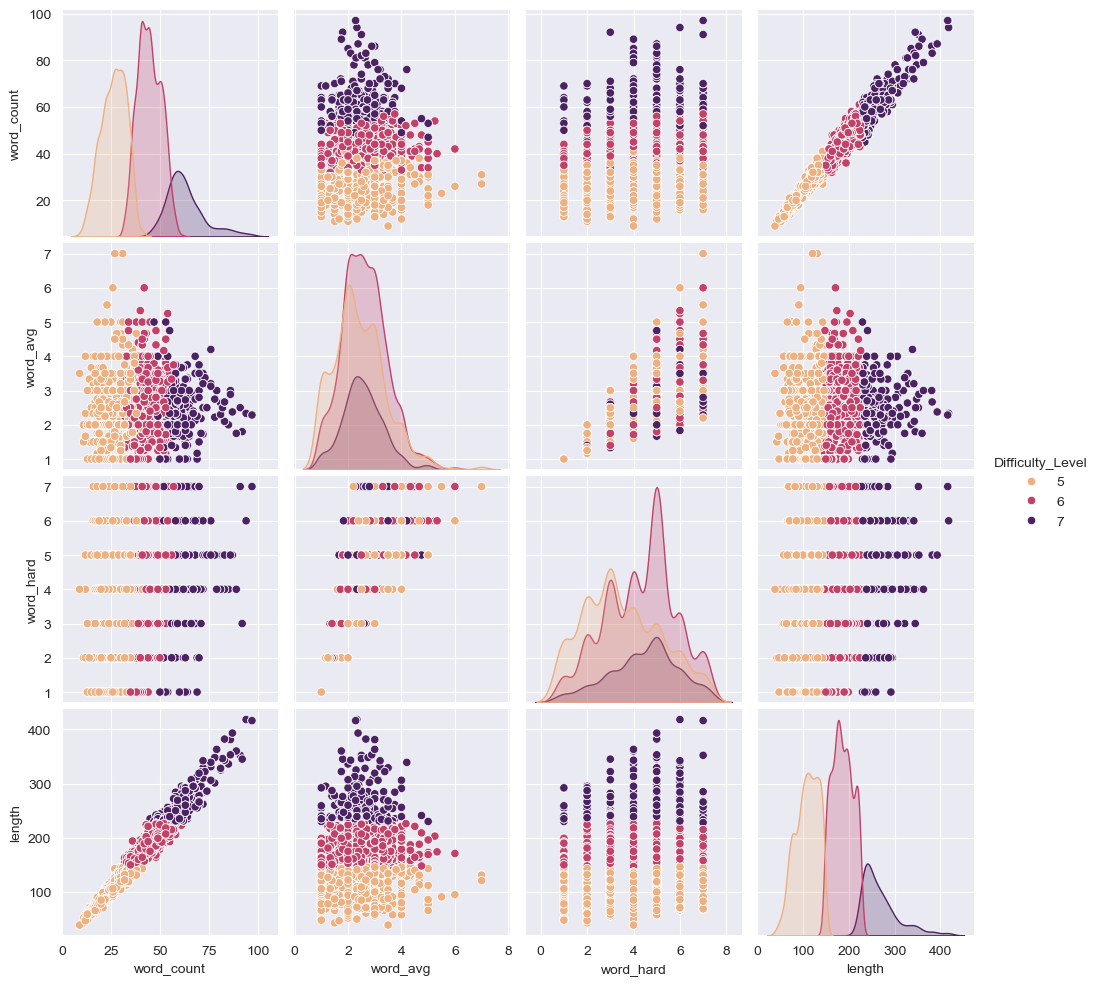

Saved difficulty levels to ../data/processed/story/detail/story456_level.csv


In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# K-means 적용
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
story456['Cluster'] = kmeans.fit_predict(story456[['word_count', 'word_avg', 'word_hard', 'length']])

# word_high 평균값이 높은 클러스터부터 높은 난이도로 분류
cluster_avg = story456.groupby('Cluster')['word_hard'].mean().sort_values()
cluster_avg_rank = cluster_avg.rank().astype(int)+4
difficulty_mapping = {cluster: rank for cluster, rank in zip(cluster_avg.index, cluster_avg_rank)}
story456['Difficulty_Level'] = story456['Cluster'].map(difficulty_mapping)

# 시각화
features = ['word_count', 'word_avg', 'word_hard', 'length', 'Difficulty_Level']
sns_plot = sns.pairplot(story456[features], hue='Difficulty_Level', palette='flare')
image_path = "../data/processed/story/detail/story456_level_pairplot.png"
sns_plot.savefig(image_path)
plt.show()


file_path = "../data/processed/story/detail/story456_level.csv"
story456.to_csv(file_path, index=False, sep=',', encoding='utf-8-sig')
print(f"Saved difficulty levels to {file_path}")

In [17]:
storypre['Cluster'] = 0
storypre['Difficulty_Level'] = 1

print(storypre)

               isbn textID classification  \
0     9788961916103  49110           의사소통   
1     9788961916103  49110           의사소통   
2     9788961916103  49110           의사소통   
3     9788961916103  49110           의사소통   
4     9788993877267  14123           의사소통   
...             ...    ...            ...   
2355  9791165431716   6279        신체운동_건강   
2356  9791165431716   6279        신체운동_건강   
2357  9791165431716   6277        신체운동_건강   
2358  9791165431716   6277        신체운동_건강   
2359  9791165431716   6277        신체운동_건강   

                                                   text  \
0     어느 마을에 릴리엔탈과 구스타프라는 형제가 살았어. 릴리엔탈과 구스타프는 어릴 때부...   
1     어느 마을에 릴리엔탈과 구스타프라는 형제가 살았어. 릴리엔탈과 구스타프는 어릴 때부...   
2     어느 마을에 릴리엔탈과 구스타프라는 형제가 살았어. 릴리엔탈과 구스타프는 어릴 때부...   
3     어느 마을에 릴리엔탈과 구스타프라는 형제가 살았어. 릴리엔탈과 구스타프는 어릴 때부...   
4     "내 짝꿍은 어디 있지?" 물방울무늬 속에 앉아 있는 친구를 찾아보세요. "내 짝꿍...   
...                                                 ...   
2355  아가는 자꾸만 흘끔흘끔. 아가 얼굴이 붉으락푸르락. “강아지랑 고양이, 

In [18]:
story = pd.concat([storypre, story123, story456], ignore_index=True)
story_pt02 = story[story['questionType'] == 'PT02'].sort_values(by='Difficulty_Level').reset_index(drop=True)
story_pt03 = story[story['questionType'] == 'PT03'].sort_values(by='Difficulty_Level').reset_index(drop=True)

story_pt02.to_csv("../data/processed/story/result/story_pt02.csv", sep=',', encoding='utf-8-sig', index=False)
story_pt03.to_csv("../data/processed/story/result/story_pt03.csv", sep=',', encoding='utf-8-sig', index=False)
story.to_csv("../data/processed/story/result/story_all.csv", sep=',', encoding='utf-8-sig', index=False)

In [19]:
print(story_pt02)

print(story_pt03)

               isbn textID classification  \
0     9788961916103  49110           의사소통   
1     9791128216381  29290           예술경험   
2     9791128216381  29297           예술경험   
3     9791128216381  29297           예술경험   
4     9791128216381  29297           예술경험   
...             ...    ...            ...   
5558  9788961910439  35786           사회관계   
5559  9788961910439  35598           사회관계   
5560  9788961910439  35598           사회관계   
5561  9788961910347  36240           사회관계   
5562  9788961910439  35667           사회관계   

                                                   text  \
0     어느 마을에 릴리엔탈과 구스타프라는 형제가 살았어. 릴리엔탈과 구스타프는 어릴 때부...   
1     그림 속에서 빠르게 걷고 있는 보이지요. 걷고 있는 개의 여러 여러 동작을 한 그림...   
2     키스. 구스타프 클림트, 1907 1908년, 벨베델 오스트리아 미술관. 황금 옷을...   
3     키스. 구스타프 클림트, 1907 1908년, 벨베델 오스트리아 미술관. 황금 옷을...   
4     키스. 구스타프 클림트, 1907 1908년, 벨베델 오스트리아 미술관. 황금 옷을...   
...                                                 ...   
5558  마침내 갈리아 지방을 정복한 카이사르는 잡은 포로들을 모두 고향으로 돌려